In [2]:
%load_ext autoreload
%autoreload 2
    
import time
import json
import os
from typing import cast, Literal, TypedDict, Any
from datetime import datetime
from multiprocessing import Process, Queue

import torch
import tensorflow as tf
import tensorflow.experimental.numpy as tnp  # type: ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from torch.utils.data import DataLoader

from delight.training.dataset import DelightDataset, DelightDatasetType
from delight.training.cnn import train_delight_cnn_model, get_delight_cnn_parameters, HyperParameters
from delight.models.cnn import DelightCnn
from delight.training.dataset import DelightDatasetOptions


SOURCE = os.path.join(os.getcwd(), "data")
RAYTUNE_EXPERIMENT_DF = os.path.join(os.getcwd(), "ray_results_df", "ray_experiment_23_11_2023-18_51_43.pkl")
PARAMS_DFCOLUMNS_MAPPING = {
    "nconv1": "config/nconv1",
    "nconv2": "config/nconv2",
    "nconv3": "config/nconv3",
    "ndense": "config/ndense",
    "dropout": "config/dropout",
    "epochs": "config/epochs",
    "batch_size": "config/batch_size",
    "lr": "config/lr",
}
DELIGHT_PAPER_PARAMS = {
    "nconv1": 52,
    "nconv2": 57,
    "nconv3": 41,
    "ndense": 685,
    "dropout": 0.06,
    "epochs": 50,
    "batch_size": 40,
    "lr": 0.0014,
}
TEST_COORDS_FILENAME = "testcoords.csv"
WEIGHTS_PATH = os.path.join(os.getcwd(), "weights")

AVAILABLES_GPU = tf.config.list_physical_devices('GPU')
assert torch.cuda.is_available() is True, "Pytorch: No cuda detected"
assert len(AVAILABLES_GPU) == 1, "Tensorflow: No GPU Devices where found: {}".format(AVAILABLES_GPU)

tf.config.set_visible_devices(AVAILABLES_GPU[0], 'GPU')
tnp.experimental_enable_numpy_behavior()  # type: ignore

2023-12-24 13:51:24.276403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 13:51:24.276462: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 13:51:24.277777: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 13:51:24.401458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 13:51:25.349647: W tensorflow/compiler/

In [3]:
def get_pytorch_model_size(model: torch.nn.Module) -> float:
    """ Returns pytorch model size in MB """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    return (param_size) / 1024**2

def get_tf_model_size(model: tf.keras.Model) -> float:
    """ Return tensorflow model size in MB """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += get_tf_model_size(layer)
        single_layer_mem = cast(int, tf.as_dtype(layer.dtype or default_dtype).size)  # type: ignore
        out_shape = cast(list[tuple[int | None]] | tuple[int], layer.output_shape)  # type: ignore
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights] # type: ignore
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights] # type: ignore
    )

    total_memory = (
        internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory * 10e-6

def get_model_size(model: torch.nn.Module | tf.keras.Model) -> float:
    """ Returns model size in MB """
    if isinstance(model, torch.nn.Module): 
        return get_pytorch_model_size(model)

    return get_tf_model_size(model)

def test_pytorch_model(dataset: DelightDataset, batch_size: int, model: torch.nn.Module, device: Literal["cuda"] | Literal["cpu"]) -> tuple[float, list[float]]:
    dl = DataLoader(dataset, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    running_loss = 0.0
    execution_times: list[float] = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(dl):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            t = time.perf_counter()
            outputs = model(inputs)
            execution_times.append((time.perf_counter() - t) * 10e2) # ms
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    accurate = running_loss / len(dl)
    return accurate, execution_times

def test_tf_model(dataset: DelightDataset, batch_size: int, model: tf.keras.Model, device: Literal["cuda"] | Literal["cpu"]) -> tuple[float, list[float]]:
    dl = tf.data.Dataset.from_tensor_slices(dataset.to_tf_dataset()).batch(batch_size)
    criterion = tf.keras.losses.MeanSquaredError()
    running_loss = 0.
    execution_times: list[float] = []
    
    for X_batch, y_batch in dl:
        X_input = [X_batch[:, :, :, i] for i in range(X_batch.shape[3])]
        y_target = y_batch.numpy()
        if device == "cpu":
            with tf.device('/device:CPU:0'):
                t = time.perf_counter()
                y_pred = model.predict(X_input, verbose=None)
        else:
            t = time.perf_counter()
            y_pred = model.predict(X_input, verbose=None)
        execution_times.append((time.perf_counter() - t) * 10e2)
        loss = criterion(y_target, y_pred)
        running_loss += loss.numpy()

    accuracy = running_loss / len(dl)
    return accuracy, execution_times
    
class BenchmarkResult(TypedDict):
    model: str
    size_mb: float
    loss_mean: float
    test_time_ms: float
    perf_time_mean_per_image_ms: float
    perf_time_mean_per_batch_ms: float
    perf_time_std_per_batch_ms: float
    perf_time_std_per_image_ms: float
    batch_size: int
    env: Literal["cuda"] | Literal["cpu"]

def test_model(dataset: DelightDataset, batch_size: int, model: torch.nn.Module | tf.keras.Model, device: Literal["cuda"] | Literal["cpu"]) -> BenchmarkResult:
    model_architecture: str
    ti = time.perf_counter()
    if isinstance(model, torch.nn.Module):
        model_architecture = "torch"
        print(f"Testing model {model_architecture} with {batch_size=} and {device=}")
        accurate, execution_times = test_pytorch_model(dataset, batch_size, model, device)
    else:
        model_architecture = "tf"
        
        print(f"Testing model {model_architecture} with {batch_size=} and {device=}")
        accurate, execution_times = test_tf_model(dataset, batch_size, model, device)

    execution_times_per_image = list(map(lambda t: t / batch_size, execution_times))
    tf = time.perf_counter()

    dt = round((tf - ti) * 10e2, 3)
    print(f"Test for {model_architecture} with {batch_size=} and {device=} finished taking {dt=} ms")
    return {
        "model": model_architecture,
        "size_mb": get_model_size(model),
        "loss_mean": accurate,
        "batch_size": batch_size,
        "test_time_ms": dt,
        "perf_time_mean_per_batch_ms": np.mean(execution_times),
        "perf_time_mean_per_image_ms": np.mean(execution_times_per_image),
        "perf_time_std_per_batch_ms": np.std(execution_times),
        "perf_time_std_per_image_ms": np.std(execution_times_per_image),
        "env": device
    }

In [4]:
def hyperparams_to_str(params: HyperParameters) -> str:
    return f"e={params['epochs']}_bs={params['batch_size']}_lr={params['lr']}_nconv1={params['nconv1']}_nconv2={params['nconv2']}_nconv3={params['nconv3']}_ndense={params['ndense']}_dp={params['dropout']}"

def sort_params_name(param_name: str) -> str:
    params_list = list(map(lambda param: tuple(param.split('=')), param_name.split('_')))
    params_list.sort(key=lambda e: e[0])
    params_list = list(map(lambda param: '='.join(param), params_list))
    return '_'.join(params_list)

def search_weights(params: HyperParameters) -> str | None:
    if not os.path.exists(WEIGHTS_PATH):
        return None

    trains_json_path = os.path.join(WEIGHTS_PATH, "DelightPt", "trains.json")
    if not os.path.exists(trains_json_path):
        return None

    with open(trains_json_path, 'r') as f:
        data = json.load(f)

    ordered_names = {sort_params_name(key): data[key] for key in data.keys()}
    target = sort_params_name(hyperparams_to_str(params))

    if target not in ordered_names:
        return None 

    weights = ordered_names[target]
    weights.sort(key=lambda t: datetime.strptime(t, "%d%m%YT%H%M%SZ"))
    return os.path.join(WEIGHTS_PATH, "DelightPt", f"{weights[0]}.pt")

def update_trains(params, dt_str) -> None:
    params_str = sort_params_name(hyperparams_to_str(params))
    trains_json_path = os.path.join(WEIGHTS_PATH, "DelightPt", "trains.json")

    if not os.path.exists(trains_json_path):
        with open(trains_json_path, 'w') as f:
            return json.dump({params_str: [dt_str]}, f, indent=4)

    with open(trains_json_path, 'r') as f:
        data = json.load(f)

    weights = data.get(params_str, [])
    if params_str in weights:
        return
        
    weights.append(dt_str)
    data[params_str] = weights

    with open(trains_json_path, 'w') as f:
        return json.dump(data, f, indent=4)


In [25]:
df_best_params = pd.read_pickle(RAYTUNE_EXPERIMENT_DF).sort_values(by="val_loss").iloc[0, :].to_dict()
# params = { key: df_best_params[value] for key, value in PARAMS_DFCOLUMNS_MAPPING.items() }
params = DELIGHT_PAPER_PARAMS

delight_options = DelightDatasetOptions(
    source=SOURCE,
    n_levels=5,
    fold=0,
    mask=False,
    object=True,
    rot=True,
    flip=True
)

weights_path = search_weights(params)

if weights_path is None:
    model_torch = train_delight_cnn_model(params, delight_options)
    dt = datetime.now().strftime("%d%m%YT%H%M%SZ")
    torch.save(model_torch.state_dict(), os.path.join(WEIGHTS_PATH, "DelightPt", dt + ".pt")) # type: ignore
    update_trains(params, dt)
    del model_torch
else:
    print(f"Loading {weights_path}")
    model_torch = DelightCnn(get_delight_cnn_parameters(params, delight_options))
    model_torch.load_state_dict(torch.load(weights_path)) # type: ignore

test_dataset = DelightDataset(options=delight_options, datatype=DelightDatasetType.TEST)

Loading /home/keviinplz/universidad/tesis/astro-delight/weights/DelightPt/24122023T015928Z.pt


In [6]:
model_tf = tf.keras.models.load_model(os.path.join(os.getcwd(), "weights", "DelightTf", "DELIGHT_v1.h5"))

2023-12-24 13:51:33.629392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 13:51:33.629446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 13:51:33.629460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 13:51:33.630092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 13:51:33.630118: I tensorflow/compile

In [7]:
batch_sizes = [16, 32, 64, 128]
devices = ["cuda", "cpu"]
models = [model_torch, model_tf]# [model_tf, model_torch]
results: list[BenchmarkResult] = []
for device in devices:
    for model in models:
        for batch_size in batch_sizes:
            results.append(test_model(test_dataset, batch_size, model, device))

benchmark_df = pd.DataFrame.from_records(results)  # type: ignore
benchmark_df

Testing model torch with batch_size=16 and device='cuda'
Test for torch with batch_size=16 and device='cuda' finished taking dt=5288.319 ms
Testing model torch with batch_size=32 and device='cuda'
Test for torch with batch_size=32 and device='cuda' finished taking dt=1805.473 ms
Testing model torch with batch_size=64 and device='cuda'
Test for torch with batch_size=64 and device='cuda' finished taking dt=1696.258 ms
Testing model torch with batch_size=128 and device='cuda'
Test for torch with batch_size=128 and device='cuda' finished taking dt=20325.789 ms
Testing model tf with batch_size=16 and device='cuda'


2023-12-24 13:52:05.749297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8
2023-12-24 13:52:06.128579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


Test for tf with batch_size=16 and device='cuda' finished taking dt=24071.329 ms
Testing model tf with batch_size=32 and device='cuda'
Test for tf with batch_size=32 and device='cuda' finished taking dt=11001.841 ms
Testing model tf with batch_size=64 and device='cuda'
Test for tf with batch_size=64 and device='cuda' finished taking dt=7436.557 ms
Testing model tf with batch_size=128 and device='cuda'
Test for tf with batch_size=128 and device='cuda' finished taking dt=5926.96 ms
Testing model torch with batch_size=16 and device='cpu'
Test for torch with batch_size=16 and device='cpu' finished taking dt=36538.946 ms
Testing model torch with batch_size=32 and device='cpu'
Test for torch with batch_size=32 and device='cpu' finished taking dt=37210.642 ms
Testing model torch with batch_size=64 and device='cpu'
Test for torch with batch_size=64 and device='cpu' finished taking dt=35892.524 ms
Testing model torch with batch_size=128 and device='cpu'
Test for torch with batch_size=128 and de

2023-12-24 13:55:20.709452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


Test for tf with batch_size=16 and device='cpu' finished taking dt=48670.403 ms
Testing model tf with batch_size=32 and device='cpu'
Test for tf with batch_size=32 and device='cpu' finished taking dt=27613.017 ms
Testing model tf with batch_size=64 and device='cpu'
Test for tf with batch_size=64 and device='cpu' finished taking dt=25678.082 ms
Testing model tf with batch_size=128 and device='cpu'
Test for tf with batch_size=128 and device='cpu' finished taking dt=21996.814 ms


,model,size_mb,loss_mean,batch_size,test_time_ms,perf_time_mean_per_batch_ms,perf_time_mean_per_image_ms,perf_time_std_per_batch_ms,perf_time_std_per_image_ms,env
0,torch,8.763062,38.038659,16,5288.319,12.617257,0.788579,189.540220,11.846264,cuda
1,torch,8.763062,38.827991,32,1805.473,1.830403,0.057200,0.877684,0.027428,cuda
2,torch,8.763062,38.555537,64,1696.258,1.967985,0.030750,1.537903,0.024030,cuda
3,torch,8.763062,40.589043,128,20325.789,6.157974,0.048109,25.952678,0.202755,cuda
4,tf,22.971840,30.367862,16,24071.329,74.132425,4.633277,141.551733,8.846983,cuda
5,tf,22.971840,30.486810,32,11001.841,68.047706,2.126491,47.593770,1.487305,cuda
6,tf,22.971840,30.605928,64,7436.557,93.100875,1.454701,3.290289,0.051411,cuda
7,tf,22.971840,31.542524,128,5926.960,147.956116,1.155907,10.087760,0.078811,cuda
8,torch,8.763062,38.038919,16,36538.946,121.577201,7.598575,9.983781,0.623986,cpu
9,torch,8.763062,38.828229,32,37210.642,247.318742,7.728711,14.446585,0.451456,cpu


In [14]:
os.makedirs("benchmarks", exist_ok=True)
benchmark_data_filename = f"benchmark_{datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl"
benchmark_df.to_pickle(os.path.join(os.getcwd(), "benchmarks", benchmark_data_filename))

## Analysis

In [15]:
benchmark_df = pd.read_pickle(os.path.join(os.getcwd(), "benchmarks", benchmark_data_filename))
df_torch = benchmark_df[benchmark_df["model"] == "torch"]
df_tf = benchmark_df[benchmark_df["model"] == "tf"]

In [16]:
def plot_benchmark_by_env_and_metric(ax: Axes, *, env: str, metric: str, title: str, ylabel: str) -> None:
    df_torch_cpu = df_torch[df_torch["env"] == env]
    df_tf_cpu = df_tf[df_tf["env"] == env]

    x = cast(np.ndarray[Literal[4], np.int64], benchmark_df["batch_size"].unique())  # type: ignore
    y_torch = cast(np.ndarray[Literal[4], np.float64], np.around(df_torch_cpu[metric].values, decimals=3))  # type: ignore
    y_tf = cast(np.ndarray[Literal[4], np.float64], np.around(df_tf_cpu[metric].values, decimals=3))  # type: ignore
    xi = range(len(x))

    ax.plot(xi, y_torch, 'bo--', label="Torch Model")  # type: ignore  
    ax.plot(xi, y_tf, 'ro--', label="TensorFlow Model")  # type: ignore

    ax.set_xticks(xi, x)  # type: ignore

    for i, value in enumerate(y_torch):
        ax.annotate(str(value), (xi[i], y_torch[i]))  # type: ignore

    for i, value in enumerate(y_tf):
        ax.annotate(str(value), (xi[i], y_tf[i]))  # type: ignore

    ax.set_title(title + f" ({env.upper()})")  # type: ignore
    ax.set_xlabel("Batch size")  # type: ignore
    ax.set_ylabel(ylabel)  # type: ignore
    ax.legend(loc='upper left')  # type: ignore


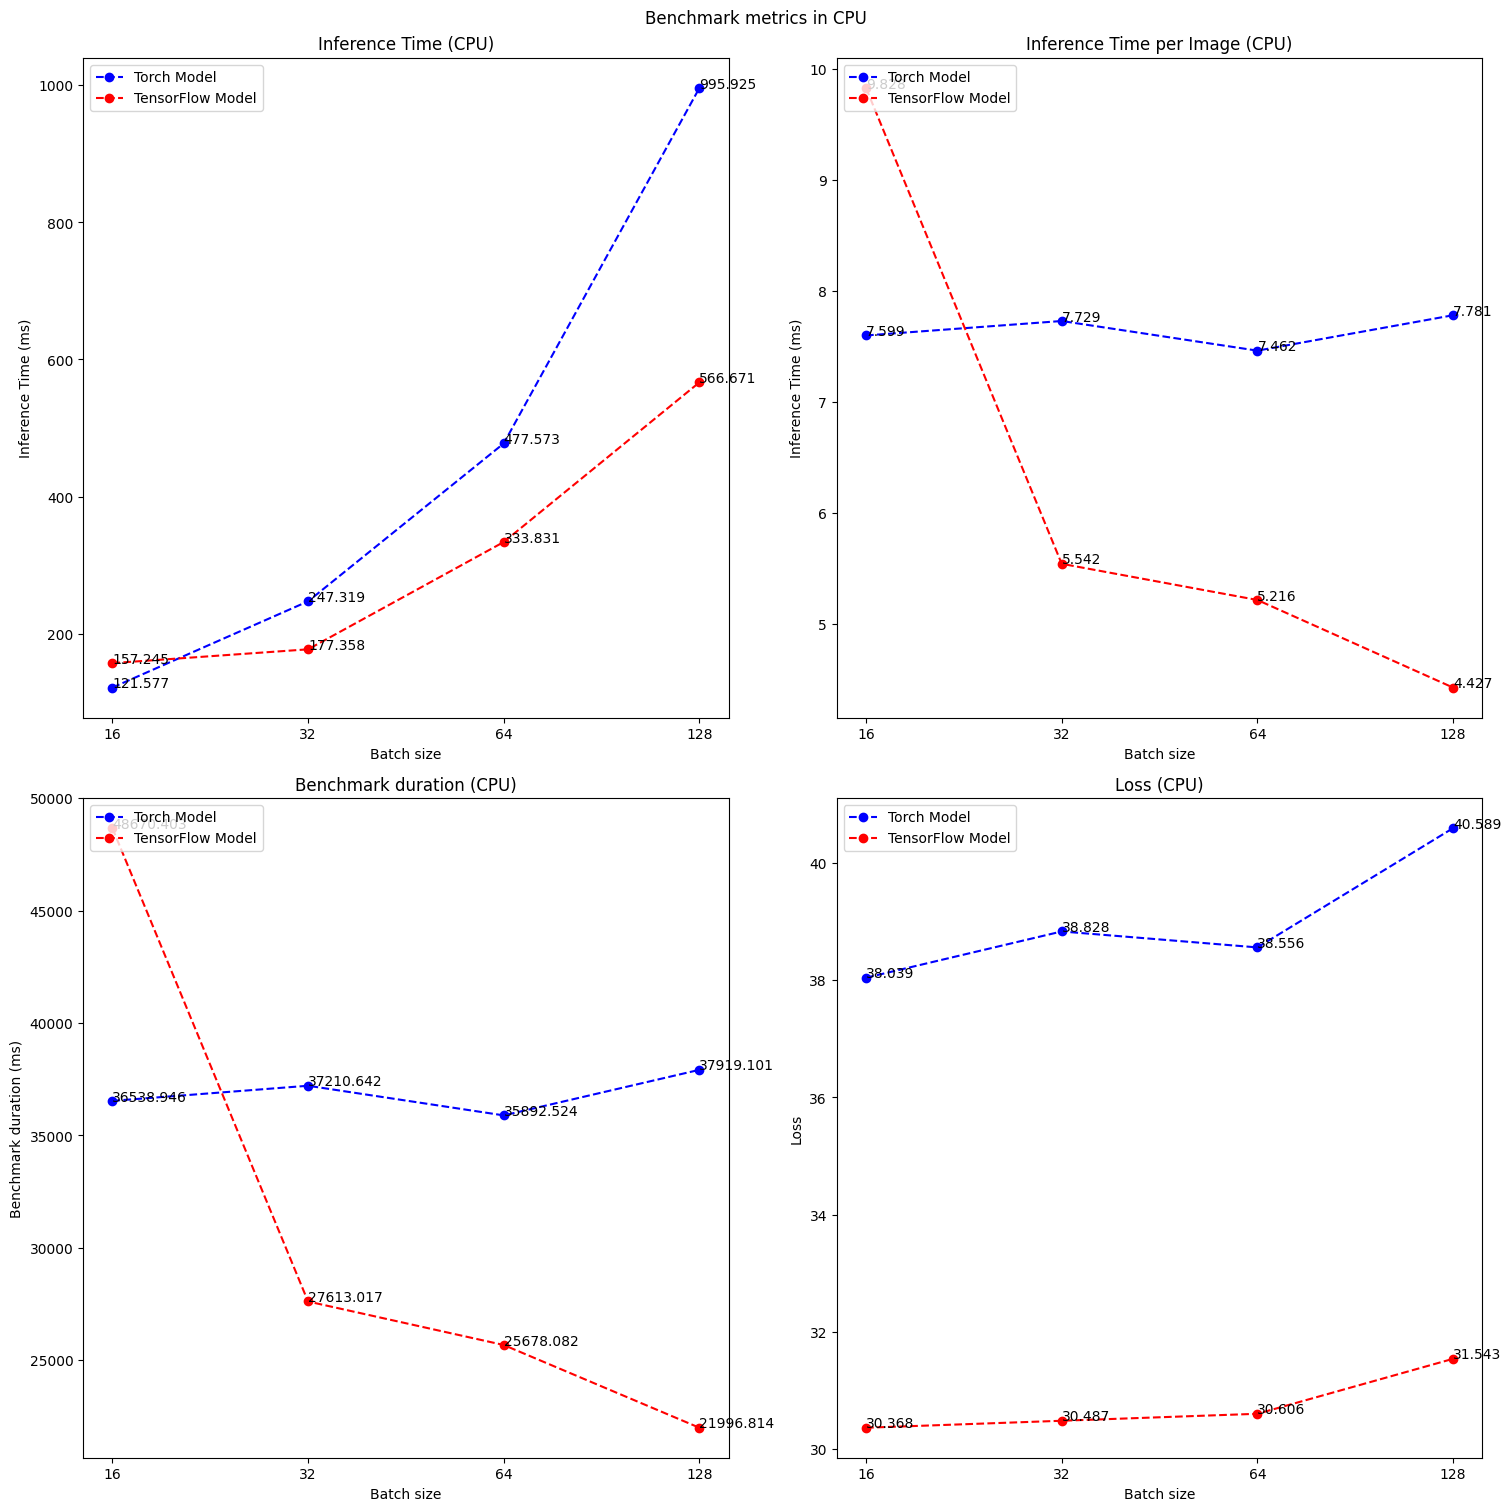

In [17]:
# CPU Performance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True)  # type: ignore
options = [
    { "env": "cpu", "metric": "perf_time_mean_per_batch_ms", "title": "Inference Time", "ylabel": "Inference Time (ms)" },
    { "env": "cpu", "metric": "perf_time_mean_per_image_ms", "title": "Inference Time per Image", "ylabel": "Inference Time (ms)" },
    { "env": "cpu", "metric": "test_time_ms", "title": "Benchmark duration", "ylabel": "Benchmark duration (ms)" },
    { "env": "cpu", "metric": "loss_mean", "title": "Loss", "ylabel": "Loss" }
]

for option, ax in zip(options, axs.flat):
    plot_benchmark_by_env_and_metric(ax, **option)

fig.suptitle('Benchmark metrics in CPU')  # type: ignore
plt.show()  # type: ignore

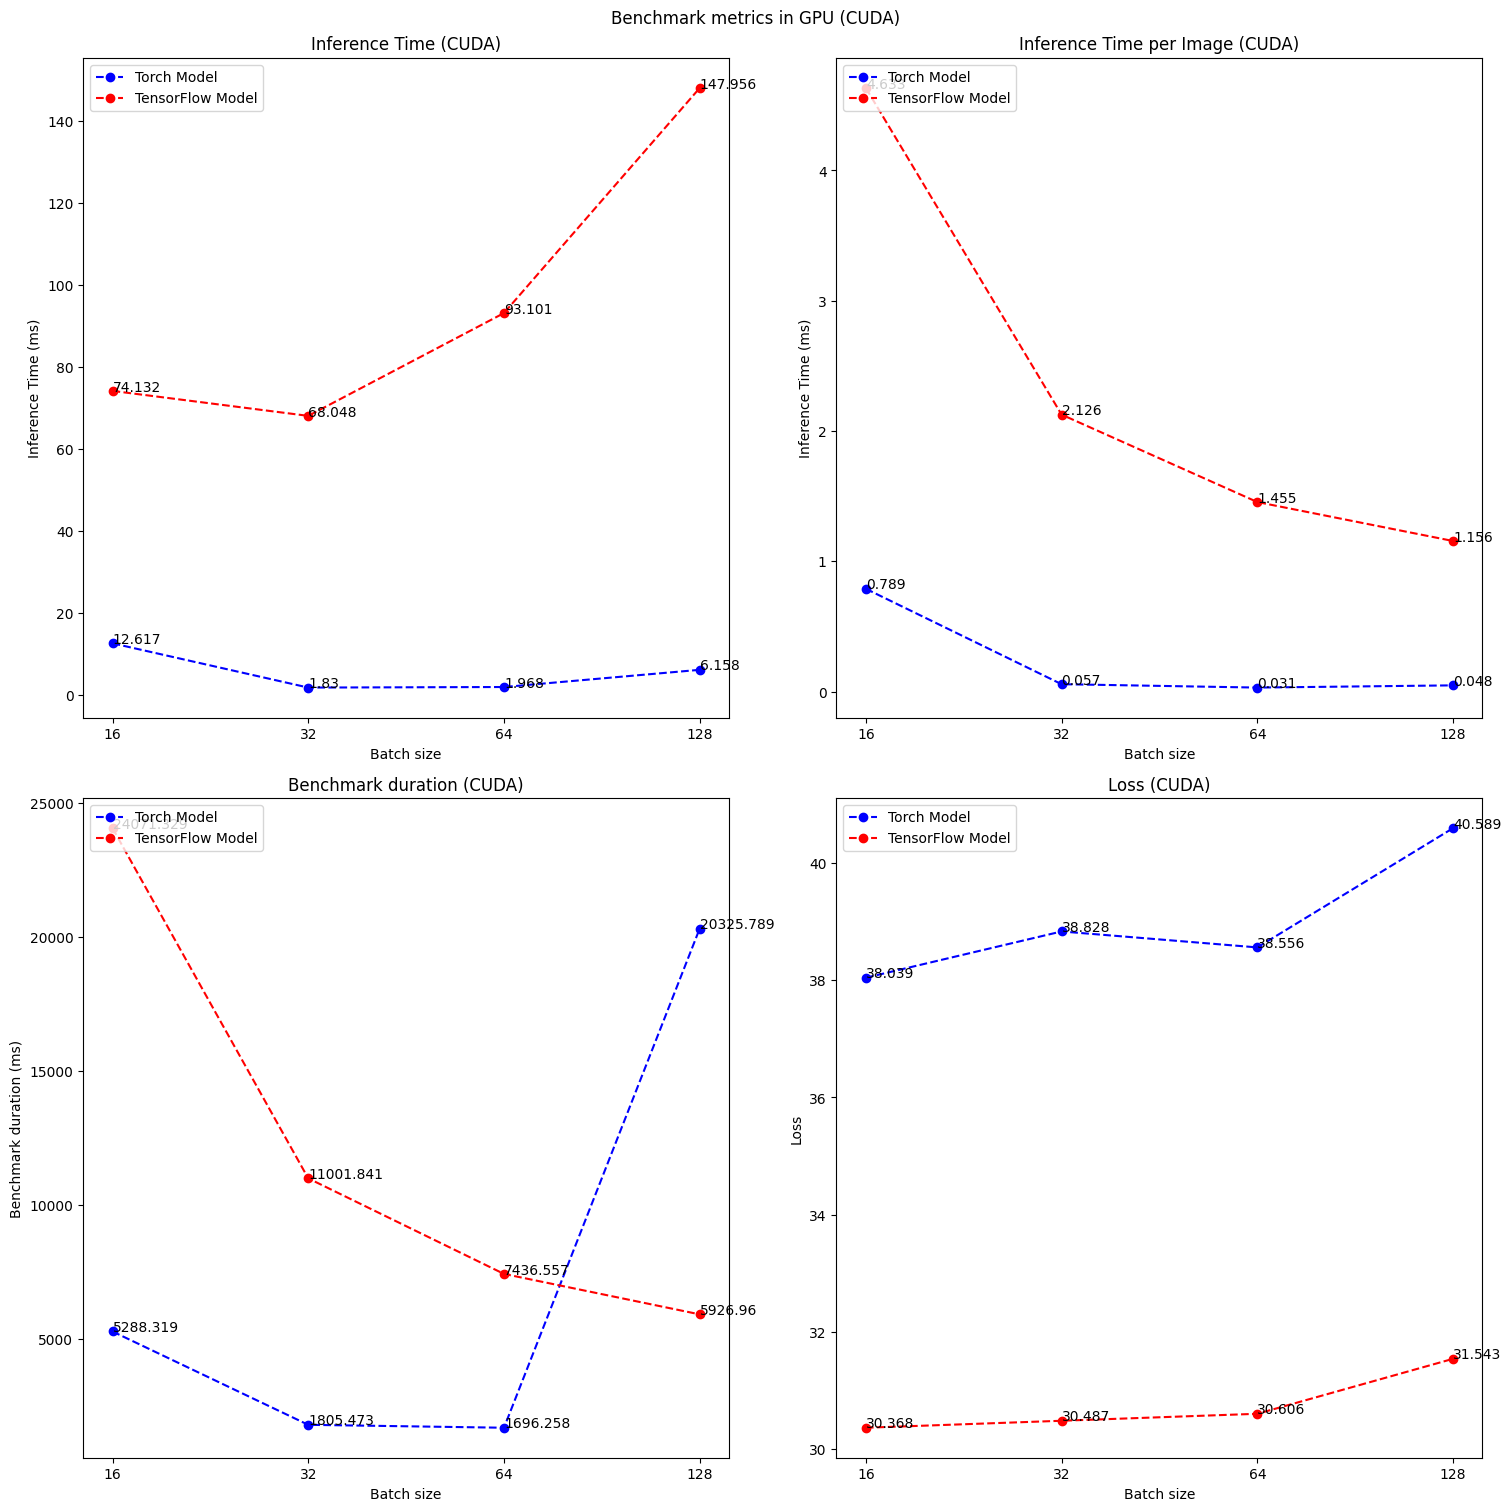

In [18]:
# GPU Performance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True)  # type: ignore
options = [
    { "env": "cuda", "metric": "perf_time_mean_per_batch_ms", "title": "Inference Time", "ylabel": "Inference Time (ms)" },
    { "env": "cuda", "metric": "perf_time_mean_per_image_ms", "title": "Inference Time per Image", "ylabel": "Inference Time (ms)" },
    { "env": "cuda", "metric": "test_time_ms", "title": "Benchmark duration", "ylabel": "Benchmark duration (ms)" },
    { "env": "cuda", "metric": "loss_mean", "title": "Loss", "ylabel": "Loss" }
]

for option, ax in zip(options, axs.flat):
    plot_benchmark_by_env_and_metric(ax, **option)

fig.suptitle('Benchmark metrics in GPU (CUDA)')  # type: ignore
plt.show()  # type: ignore

# Análisis conjunto test

In [27]:
def derotate(y_pred, reg=False):
    return np.dstack([y_pred.reshape((y_pred.shape[0], 8, 2))[:, 0],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 1, ::-1] * [1, -1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 2, :] * [-1, -1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 3, ::-1] * [-1, 1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 4, :] * [1, -1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 5, ::-1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 6, :] * [-1, 1],
      y_pred.reshape((y_pred.shape[0], 8, 2))[:, 7, ::-1] * [-1, -1]]).reshape((y_pred.shape[0], 2, 8)).swapaxes(1, 2)
    
    return y_pred

In [31]:
DATA_SAMPLE_RATE = 20 # Percentaje of data

test_data = DelightDataset(options=delight_options, datatype=DelightDatasetType.TEST)
X_test, y_test = test_data.X, test_data.y
batchs, levels, width, height = X_test.shape
X_test = X_test.reshape(batchs, levels, 1, width, height)

In [33]:
DATA_SAMPLE_INDEX = int(len(X_test) * DATA_SAMPLE_RATE
y_pred = model_torch.forward(X_test)

RuntimeError: [enforce fail at alloc_cpu.cpp:83] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 33605877760 bytes. Error code 12 (Cannot allocate memory)